<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Efficient Frontier - Part III - Running the Optimizer

In order to plot the frontier for portfolios with more than 2 assets, we need to find the weights of the portfolio on the efficient frontier.

We start by creating the same sort of function that we already created for the 2 asset case:

```python

def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    weights = ???? # we need to implement: optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-')
```

But let's start by loading up the data as usual:


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import edhec_risk_kit as erk

ind = erk.get_ind_returns()
er = erk.annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()

ModuleNotFoundError: No module named 'edhec_risk_kit'

In order to find the optimal weights, we need a function that will minimize the volatility for a given level of return.


```python
from scipy.optimize import minimize

def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - erk.portfolio_return(weights,er)
    }
    weights = minimize(erk.portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x
```

Let's use this to recreate the result we got from frontier for the 2-Asset optimization between "Games" and "Fin". Let's plot that efficient frontier as we did last time:

In [2]:
l = ["Games", "Fin"]
erk.plot_ef2(20, er[l], cov.loc[l,l])

NameError: name 'erk' is not defined

The Efficient Frontier for the protfolio that has a target return of 0.15 is approx 0.056, so let's see if our optimizer is able to locate it.

In [4]:
weights_15 = erk.minimize_vol(0.15, er[l], cov.loc[l,l])
vol_15 = erk.portfolio_vol(weights_15, cov.loc[l,l])
vol_15

0.056163669406706564

Perfect!

Now that we can find the weights to minimize the vol given a target return, we can plot the efficient frontier by dividing up the range from the highest to the lowest possible return into a grid, and finding the portfolio that targets the minimum volatility given a particular targeted rate of return.

Add these:

```python
def optimal_weights(n_points, er, cov):
    """
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov) # not yet implemented!
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-')
```


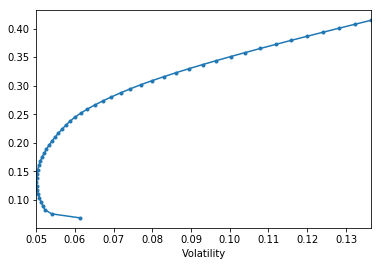

In [12]:
l = ["Smoke", "Fin", "Games", "Coal"]
erk.plot_ef(50, er[l], cov.loc[l,l])